In [16]:
import importlib
import active_clustering
from active_clustering import *
importlib.reload(active_clustering)


<module 'active_clustering' from '/home/bk/dev/seminar/active_clustering.py'>

# Read the xes data

In [19]:
# filename = 'filtered_3way_after_80%.xes'
filename = 'PrepaidTravelCost.xes'
log, VARIANT = read_xes(filename,1)


length of trace 2099 
length of event 18246 
number of variants : 202


#  Active clustering

****************************************************************************************************
START OF No. 0 CLUSTERING


Clustering() is called. mcs:0.25, tf:1, w:1
----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is empty set - size of |C|:0 ->  R[0] or  is to be added.


 * Fitness check to be done with cur_dpi
	 B,C,H,A,G,F,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 1 / size of R: 201 / size of I: 0


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,C,J,H,A,G,K,F,D,E... with dist 0.0

 * Fitness check to be done with cur_dpi
	 B,C,J,H,A

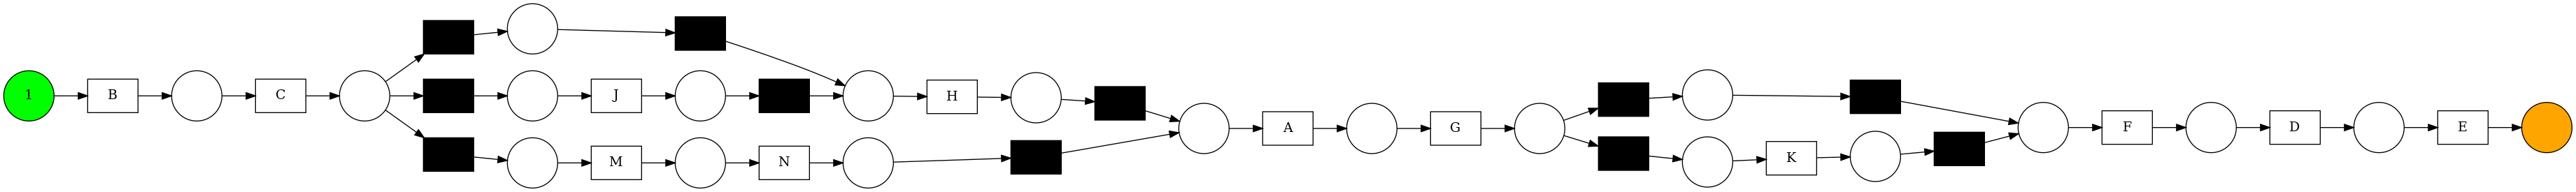

COMPLETION OF SINGLE CLUSTERING 0.5207241543592187 % been clustered (1093 out of 2099)
****************************************************************************************************
START OF No. 1 CLUSTERING


Clustering() is called. mcs:0.25, tf:1, w:1
----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is empty set - size of |C|:0 ->  R[0] or  is to be added.


 * Fitness check to be done with cur_dpi
	 B,C,J,M,N,A,G,K,F,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 1 / size of R: 198 / size of I: 0


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() 

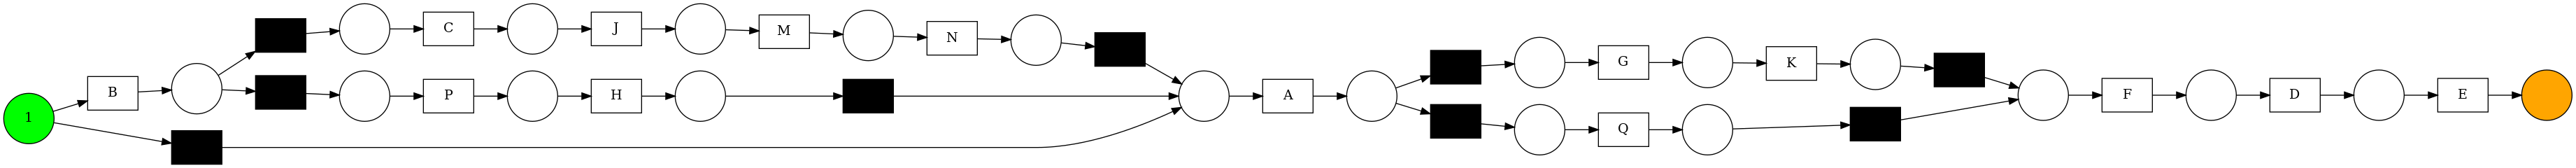

COMPLETION OF SINGLE CLUSTERING 0.3835159599809433 % been clustered (805 out of 2099)
****************************************************************************************************
START OF No. 2 CLUSTERING


Clustering() is called. mcs:0.25, tf:1, w:1
----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is empty set - size of |C|:0 ->  R[0] or  is to be added.


 * Fitness check to be done with cur_dpi
	 A,G,F,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 1 / size of R: 193 / size of I: 0


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,H,A,F,D,

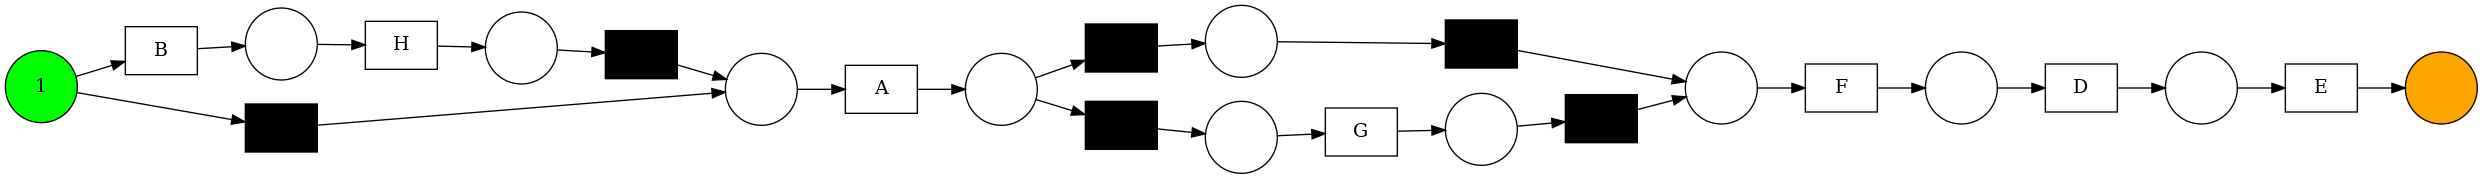

COMPLETION OF SINGLE CLUSTERING 0.2996665078608861 % been clustered (629 out of 2099)
****************************************************************************************************
START OF No. 3 CLUSTERING


Clustering() is called. mcs:0.25, tf:1, w:1
----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is empty set - size of |C|:0 ->  R[0] or  is to be added.


 * Fitness check to be done with cur_dpi
	 B,C,H,A,L,I,A,G,F,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 1 / size of R: 190 / size of I: 0


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :


 * CASE of fit 0.9994047619047619 < 1 tf -> fitness dropped than the tf
	 - CASE of |C|104 <= 131.25 mcs*|R| -> still it need more trace, cur_dpi added to I and the loop continues 

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 7 / size of R: 184 / size of I: 7


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,C,M,N,A,L,I,A,G,T,U,D,E... with dist 0.0

 * Fitness check to be done with cur_dpi
	 B,C,M,N,A,L,I,A,G,T,U,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 8 / size of R: 183 / size of I: 7


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C


 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 11 / size of R: 180 / size of I: 16


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,C,H,A,G,K,F,D,E... with dist 0.9090909090909091

 * Fitness check to be done with cur_dpi
	 B,C,H,A,G,K,F,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 12 / size of R: 179 / size of I: 16


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi v

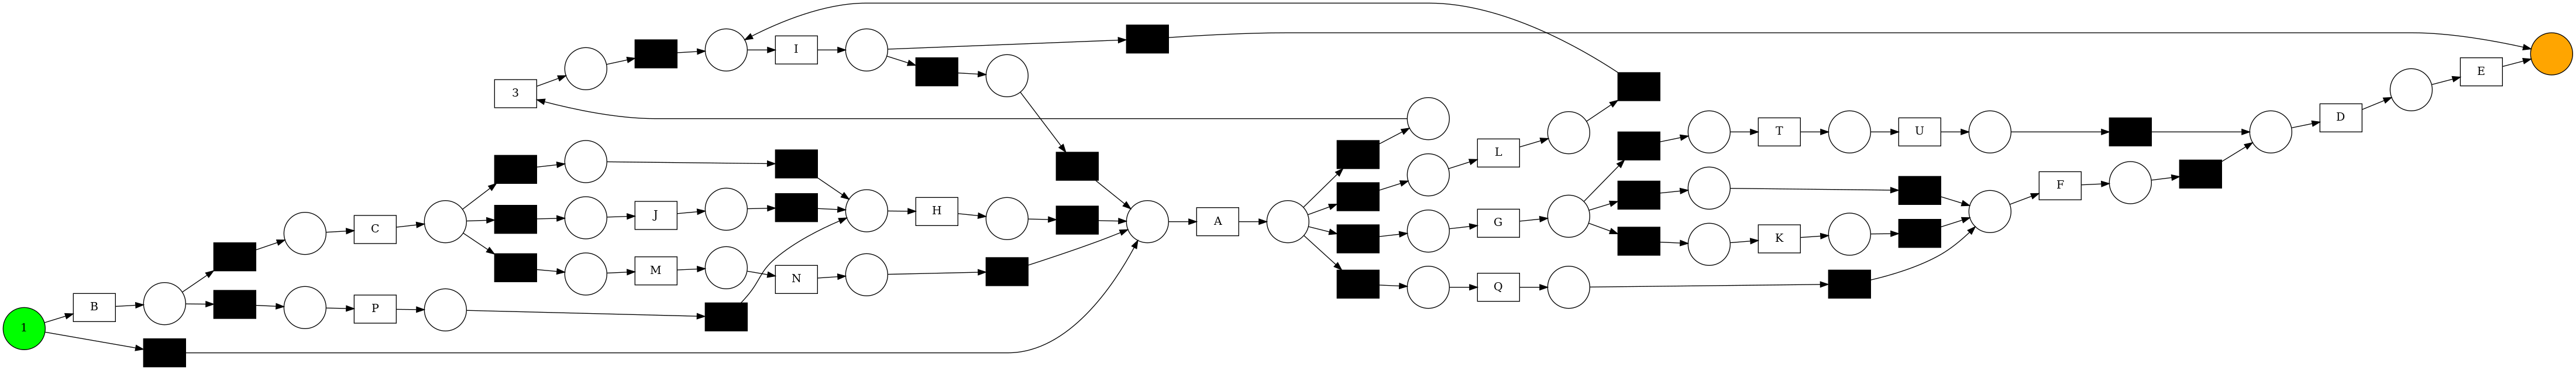

COMPLETION OF SINGLE CLUSTERING 0.2067651262505955 % been clustered (434 out of 2099)
****************************************************************************************************
START OF No. 4 CLUSTERING


Clustering() is called. mcs:0.25, tf:1, w:1
----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is empty set - size of |C|:0 ->  R[0] or  is to be added.


 * Fitness check to be done with cur_dpi
	 B,C,A,G,H,F,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 1 / size of R: 164 / size of I: 0


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,C,

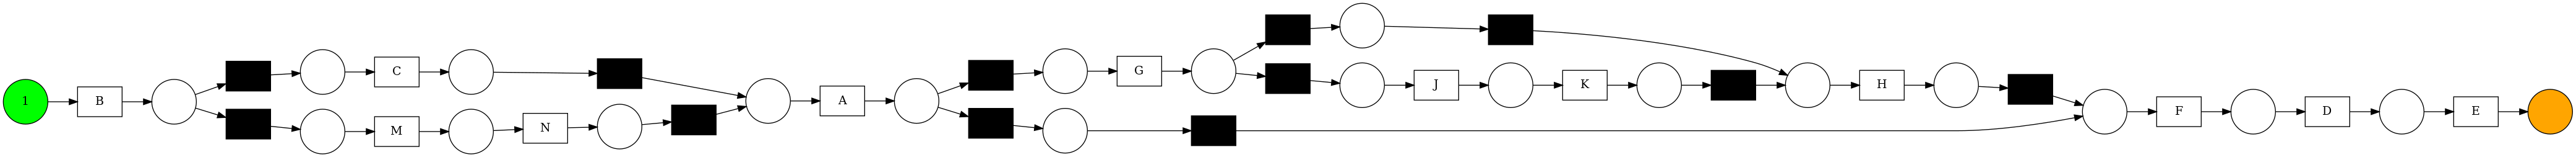

COMPLETION OF SINGLE CLUSTERING 0.162934730824202 % been clustered (342 out of 2099)
****************************************************************************************************
START OF No. 5 CLUSTERING


Clustering() is called. mcs:0.25, tf:1, w:1
----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is empty set - size of |C|:0 ->  R[0] or  is to be added.


 * Fitness check to be done with cur_dpi
	 B,C,A,G,F,H,D,E...

 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 1 / size of R: 161 / size of I: 0


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,C,J


 * CASE of fit 1.0 >= 1 tf -> Cur_dpi is added to cluster C & removed from R
	

END OF LOOP with cur_dpi____fit : 1.0 / size of C: 7 / size of R: 155 / size of I: 7


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,C,M,A,G,F,N,D,E... with dist 0.0

 * Fitness check to be done with cur_dpi
	 B,C,M,A,G,F,N,D,E...

 * CASE of fit 0.9898329129886505 < 1 tf -> fitness dropped than the tf
	 - CASE of |C|57 <= 71.25 mcs*|R| -> still it need more trace, cur_dpi added to I and the loop continues 

END OF LOOP with cur_dpi____fit : 0.99 / size of C: 7 / size of R: 155 / size of I: 8


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set


 * CASE of fit 0.9669934640522875 < 1 tf -> fitness dropped than the tf
	 - CASE of |C|66 <= 69.0 mcs*|R| -> still it need more trace, cur_dpi added to I and the loop continues 

END OF LOOP with cur_dpi____fit : 0.97 / size of C: 10 / size of R: 152 / size of I: 18


----------------------------------------------------------------------------------------------------
START OF LOOP with cur_dpi // R and I comparision : False

 * C is not empty set and W is larger than 1, so w in W to be selected with min_dist

 * Selected dpi via dpi_finder() :
	B,H,P,A,Q,F,D,E... with dist 0.0

 * Fitness check to be done with cur_dpi
	 B,H,P,A,Q,F,D,E...

 * CASE of fit 0.9510695187165773 < 1 tf -> fitness dropped than the tf
	 - CASE of |C|66 <= 69.0 mcs*|R| -> still it need more trace, cur_dpi added to I and the loop continues 

END OF LOOP with cur_dpi____fit : 0.95 / size of C: 10 / size of R: 152 / size of I: 19


----------------------------------------------------------------------------------

	 = 140 dpi(s) checked

 * Clustering completed
		B,C,A,G,F,H,D,E
		B,C,J,H,A,L,I
		B,P,M,N,A,Q,F,D,E
		B,H,A,Q,F,D,E
		B,C,J,M,N,A,G,K,T,U,D,E
		B,C,A,G,J,K,M,F,N,D,E
		B,H,A,G,K,F,D,E
		B,C,J,H,Y
		B,C,Y,J,H
		B,P,A,Q,F,H,D,E
		B,H,A,S,I
		B,C,A,G,F,D,E,H
		A,G,K,T,U,D,E
		B,P,M,N,A,G,F,D,E
		B,C,J,M,N,A,L,I
		B,C,J,M,N,A,G,F,D,E
		B,C,A,G,J,K,F,H,D,E
		B,C,J,H,A,G,K,T,U,D,E


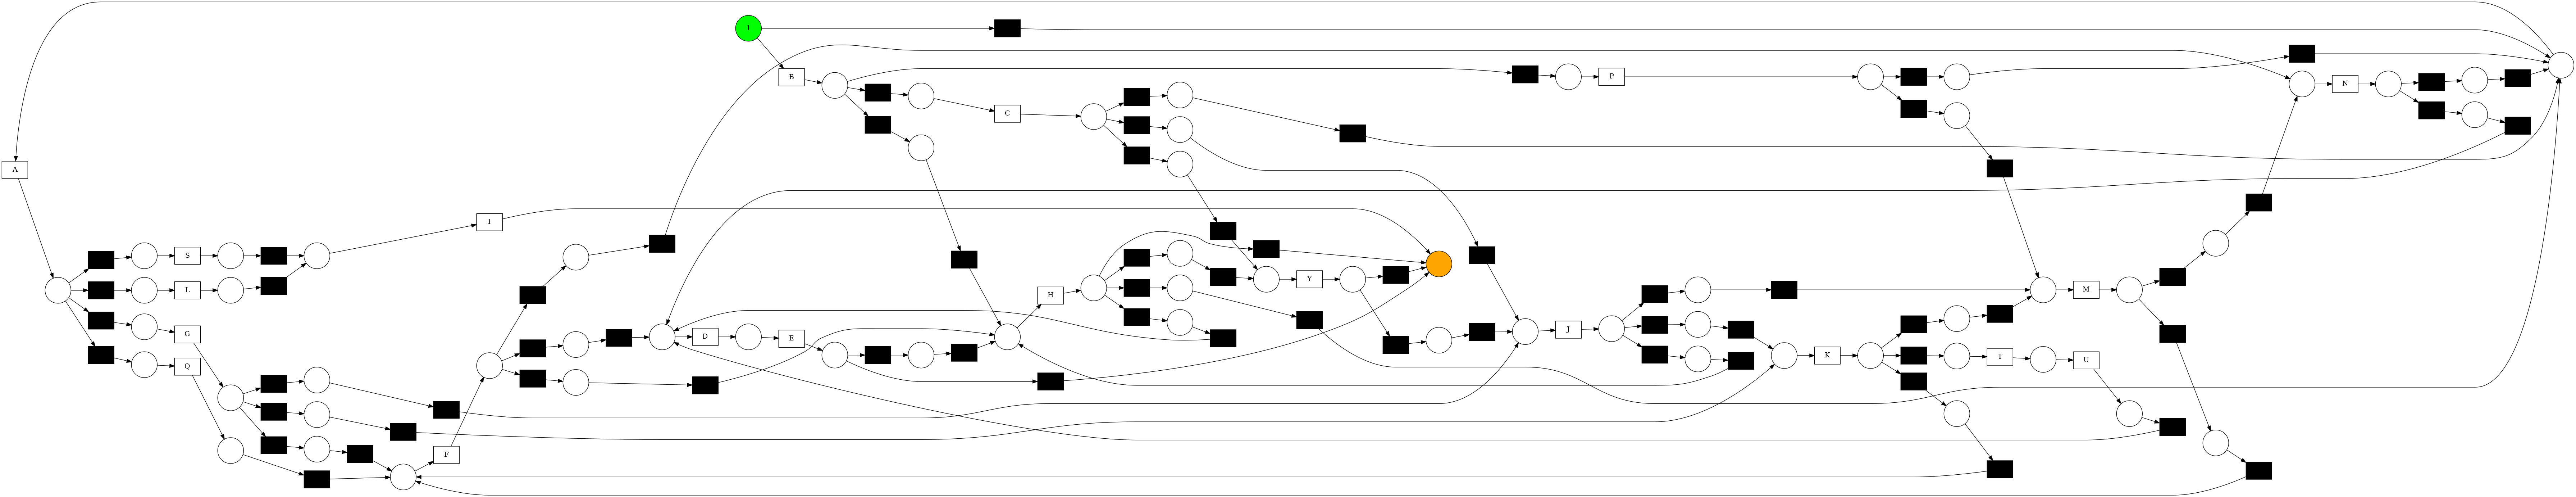

COMPLETION OF SINGLE CLUSTERING 0.126250595521677 % been clustered (265 out of 2099)
COMPLETION OF WHOLE CLUSTERING

STEP 3_ since N = 1, all the remaining traces are collected into new single cluster


In [20]:
CS = A_clustering(
    log, VARIANT,
    w = 1,  tf = 1, nb_clus = 7, mcs = 0.25,
    N = 1
)

In [ ]:
visualization_total(log, VARIANT, CS)

# save for the future job

In [ ]:
#for f1 score measurement 
# RECALL can be approximated by fitness
# ACCURACY can be approximated by precision
from pm4py.evaluation.precision import evaluator as precision_evaluator
net, im, fm = heuristics_miner.apply(variants_filter.apply(log, C))
prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

In [ ]:
#for complexity measurement
places = net.places
transitions = net.transitions
arcs = net.arcs

import time
cur_time = time.strftime("%Y%m%d-%H%M%S")
log_file = 'clustering_log' + cur_time + '.txt'
f=open(log_file,'w')

f.close()

In [ ]:
import clustering_util
import ngram_clustering
import importlib
from ngram_clustering import *
from clustering_util import *
importlib.reload(ngram_clustering) #for iterative coding enviroment, it loads the library again
importlib.reload(clustering_util)

In [ ]:
CS = CS_creator(VARIANT, type='ngram', n=5, k=3)

In [ ]:
visualization_total(log, VARIANT, CS)


In [ ]:
CS

# MRA based distance

In [ ]:
def mra_feature_generator(variant_list) : 
    features = set()
    for v in variant_list : 
        features = features.union(set(v.split(',')))
    return features



In [ ]:
features=set()
   
for v in VARIANT : 
     features = features.union(
         set(discover_maximal_repeat(v.split(',')))
     )

In [ ]:
len(features)

In [ ]:
feature_space=list(features)
result=pd.DataFrame(columns=feature_space)
for variant in VARIANT :
    v=discover_maximal_repeat(variant.split(','))
    print(v)
    A=pd.DataFrame(np.ones((1,len(v))), columns=v)
    result=result.append(A)
result=result.fillna(0)

In [ ]:
data=np.array(result)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(data)

In [ ]:
kmeans.labels_

In [ ]:
np.unique(kmeans.labels_)

In [ ]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))


In [ ]:
for v in np.array(VARIANT)[kmeans.labels_ == 2] :
    print(discover_maximal_repeat(v.split(',')))

In [ ]:
visualization(log, VARIANT, True, False)

In [ ]:
for i in np.unique(kmeans.labels_) : 
    c=np.array(VARIANT)[kmeans.labels_ == i]
    visualization(log, c, True, False)
    